In [263]:
import numpy as np

iterations_number = 25
X0 = np.array([2.71, 2.23])
optimal_x = np.array([])

In [264]:
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["figure.figsize"] = [12,12]
def fix_scaling(ax=None):
    if not ax:
        xlim = plt.xlim()
        ylim = plt.ylim()
        d1 = xlim[1] - xlim[0]
        d2 = ylim[1] - ylim[0]
        if d1 > d2:
            plt.ylim((ylim[0] - (d1-d2) / 2, ylim[1] + (d1-d2) / 2))
        else:
            plt.xlim((xlim[0] + (d1-d2) / 2, xlim[1] - (d1-d2) / 2))
    else:
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        d1 = xlim[1] - xlim[0]
        d2 = ylim[1] - ylim[0]
        if d1 > d2:
            ax.set_ylim((ylim[0] - (d1-d2) / 2, ylim[1] + (d1-d2) / 2))
        else:
            ax.set_xlim((xlim[0] + (d1-d2) / 2, xlim[1] - (d1-d2) / 2))

In [265]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
def animate_trajectory(traj):
    fig, ax = plt.subplots()
    n = len(traj)
    def step(t):
        ax.cla()
        ax.plot([optimal_x[0]], [optimal_x[1]], 'o', color='green')
        #Level contours
        delta = 0.025
        x = np.arange(-0.5, 4, delta)
        y = np.arange(-0.5, 4, delta)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i][j] = func([X[i][j], Y[i][j]])
        CS = ax.contour(X, Y, Z, [0.5, 1.5, 3], colors=['blue', 'purple', 'red'])

        
        # bug fixed: t -> t + 1
        ax.plot([u[0] for u in traj[:t + 1]], [u[1] for u in traj[:t + 1]], color='black')
        ax.plot([u[0] for u in traj[:t + 1]], [u[1] for u in traj[:t + 1]], 'o', color='black')
        
        fix_scaling(ax)
        ax.axis('off')
    
    plt.close() # fixed odd picture

    return FuncAnimation(fig, step,
                     frames=range(n), interval=600)

In [266]:
# Task 1A
a = 1.0 # Alexander
b = 22.0 # Fedorov
def func(x):
    return a * x[0] ** 2 + b * (x[0] - x[1]) ** 2 - x[0] - 2 * x[1]
def func_grad(x):
    return a * np.array([2 * x[0], 0]) + b * 2 * (x[0] - x[1]) * np.array([1, -1]) - np.array([1, 0]) - np.array([0, 2])

gessian = np.array([[2 * (a + b), -2 * b], [-2 * b, 2 * b]])
eigen_values = list(np.linalg.eig(gessian)[0])
m = min(eigen_values)
M = max(eigen_values)

In [267]:
# Task 1C (part 1)
def optimal_point():
    b = np.array([1, 2])
    return np.linalg.solve(gessian, b)

optimal_x = optimal_point()

In [268]:
# Task 1B

def make_animation(build_trajectory):
    base_animation = animate_trajectory(build_trajectory(X0))
    return HTML(base_animation.to_html5_video())  

In [269]:
# optimal step
def optimal_step_trajectory(x0):
    alpha = 2.0 / (m + M)
    cur_x = x0
    trajectory = [cur_x]
    
    for i in range(iterations_number):
        cur_x = cur_x - alpha * func_grad(cur_x)
        trajectory.append(cur_x)
        
    return trajectory    

make_animation(optimal_step_trajectory) 

In [270]:
# Chebyshev
def chebyshev_trajectory(x0):
    phi = (m + M) / (M - m)
    cur_gamma = 1.0 / phi
    prev_gamma = 0.0
    cur_x = x0
    trajectory = [cur_x]
    prev_x = x0
    
    for i in range(iterations_number):
        alpha = 4 * cur_gamma / (M - m)
        beta = cur_gamma * prev_gamma
        prev_x, cur_x = cur_x, cur_x - alpha * func_grad(cur_x) + beta * (cur_x - prev_x)
        prev_gamma, cur_gamma = cur_gamma, 1.0 / (2 * phi - cur_gamma)
        trajectory.append(cur_x)
                          
    return trajectory

make_animation(chebyshev_trajectory) 

In [271]:
# heavy ball
def heavy_ball_trajectory(x0):
    alpha = 4.0 / (np.sqrt(m) + np.sqrt(M)) ** 2
    beta = (np.sqrt(M) - np.sqrt(m)) / (np.sqrt(M) + np.sqrt(m))
    cur_x = x0
    prev_x = x0
    trajectory = [cur_x]
    
    for i in range(iterations_number):
        prev_x, cur_x = cur_x, cur_x - alpha * func_grad(cur_x) + beta * (cur_x - prev_x)
        trajectory.append(cur_x)
        
    return trajectory    

make_animation(heavy_ball_trajectory) 

In [272]:
# Nesterov
def nesterov_trajectory(x0):
    phi = 1.0 / M
    beta = (np.sqrt(M) - np.sqrt(m)) / (np.sqrt(M) + np.sqrt(m))
    cur_x = x0
    cur_y = x0
    trajectory = [cur_x]
    
    for i in range(iterations_number):
        prev_x, cur_x = cur_x, cur_y - phi * func_grad(cur_y)
        cur_y = cur_x + beta * (cur_x - prev_x)
        trajectory.append(cur_x)
        
    return trajectory    

make_animation(nesterov_trajectory) 

In [273]:
# magic
def magic_trajectory(x0):
    cur_x = x0
    trajectory = [cur_x]
    
    for i in range(2):
        cur_x = cur_x - 1.0 / eigen_values[i % 2] * func_grad(cur_x)
        trajectory.append(cur_x)
        
    return trajectory

make_animation(magic_trajectory)

In [274]:
# critical step
def critical_step_trajectory(x0):
    alpha = 2.0 / M - 0.1 ** 5
    cur_x = x0
    trajectory = [cur_x]
    
    for i in range(iterations_number):
        cur_x = cur_x - alpha * func_grad(cur_x)
        trajectory.append(cur_x)
        
    return trajectory

make_animation(critical_step_trajectory)

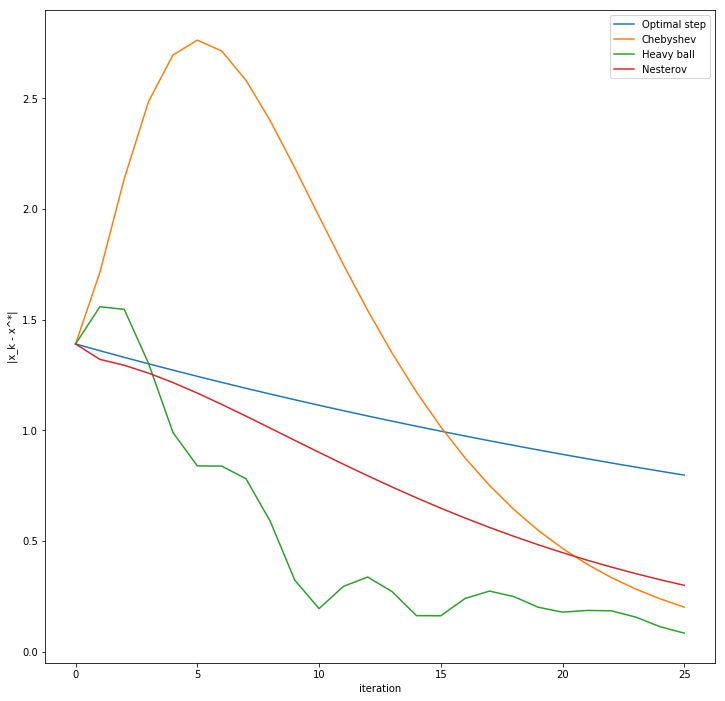

In [275]:
# Task 1 C (part 2)

# |x_k - x^*|
fig, ax = plt.subplots()

def add_subplot_trajectory(ax, trajectory, name, opt):
    ax.plot(range(len(trajectory)), [ np.linalg.norm(opt - p) for p in trajectory], label = name)

add_subplot_trajectory(ax, optimal_step_trajectory(X0), "Optimal step", optimal_x)
add_subplot_trajectory(ax, chebyshev_trajectory(X0), "Chebyshev", optimal_x)
add_subplot_trajectory(ax, heavy_ball_trajectory(X0), "Heavy ball", optimal_x)
add_subplot_trajectory(ax, nesterov_trajectory(X0), "Nesterov", optimal_x)

plt.legend()
plt.xlabel("iteration")
plt.ylabel("|x_k - x^*|")
plt.show()
plt.close()  


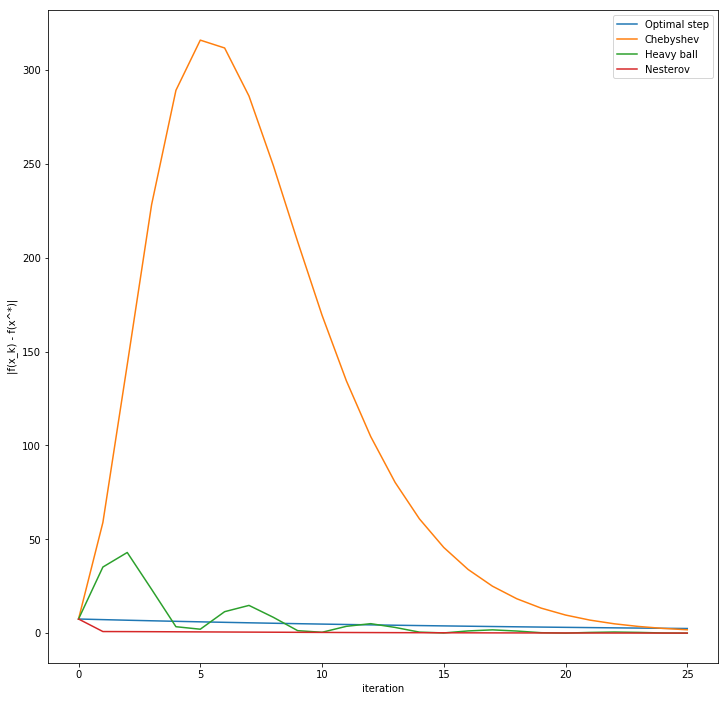

In [276]:
# |f(x_k) - f(x^*)|
fig, ax = plt.subplots()

add_subplot_trajectory(ax, map(func, optimal_step_trajectory(X0)), "Optimal step", func(optimal_x))
add_subplot_trajectory(ax, map(func, chebyshev_trajectory(X0)), "Chebyshev", func(optimal_x))
add_subplot_trajectory(ax, map(func, heavy_ball_trajectory(X0)), "Heavy ball", func(optimal_x))
add_subplot_trajectory(ax, map(func, nesterov_trajectory(X0)), "Nesterov", func(optimal_x))

plt.legend()
plt.xlabel("iteration")
plt.ylabel("|f(x_k) - f(x^*)|")
plt.show()
plt.close() 

In [277]:
# Task 1D
def animate_all_trajectories(trajectories, names, colors):
    fig, ax = plt.subplots()
    n = max(map(lambda t : len(t), trajectories))
    def step(t):
        ax.cla()
        ax.plot([optimal_x[0]], [optimal_x[1]], 'o', color='green')
        #Level contours
        delta = 0.025
        x = np.arange(-0.5, 4, delta)
        y = np.arange(-0.5, 4, delta)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i][j] = func([X[i][j], Y[i][j]])
        CS = ax.contour(X, Y, Z, [0.5, 1.5, 3], colors=['blue', 'purple', 'red'])

        for (traj, name, c) in zip(trajectories, names, colors):
            ax.plot([u[0] for u in traj[:t + 1]], [u[1] for u in traj[:t + 1]], color = c, label = name)
            ax.plot([u[0] for u in traj[:t + 1]], [u[1] for u in traj[:t + 1]], 'o', color=c)
        
        fig.legend()
        fix_scaling(ax)
        ax.axis('off')
    
    plt.close() # fixed odd picture

    return FuncAnimation(fig, step,
                     frames=range(n), interval=600)

trajectories = [optimal_step_trajectory(X0), chebyshev_trajectory(X0), heavy_ball_trajectory(X0), nesterov_trajectory(X0)]
names = ["Optimal step", "Chebyshev", "Heavy ball", "Nesterov"]
colors = ["black", "red", "blue", "purple"]


base_animation = animate_all_trajectories(trajectories, names, colors)
HTML(base_animation.to_html5_video())  